### Imports

In [130]:
import mltfm.generate_data
from DL_TFM.scripts.tracNet import TracNet
from DL_TFM.scripts.training_and_evaluation import predictTrac
from DL_TFM.scripts.data_preparation import reshape

from scipy.io import savemat, loadmat

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import keras

Set seeds for reproducability.

In [110]:
random_seed = 2
np.random.seed(random_seed)
torch.manual_seed(random_seed)

In [111]:
device = torch.device('cpu')

### Evaluation

In this notebook I will compare the performance of five approaches to TFM, namely

    1. TracNet_MATLAB by Wang & Lin
    2. TracNet_Pytorch_SGD by Richard & Sabaß
    3. TracNet_Pytorch_ADAM by Richard & Sabaß
    4. BFTTC by Sabaß
    5. low_noise_UNET by TU Dortmund
    5. high_noise_UNet by TU Dortmund
    
The test data includes both artificially created, labeled data from several research groups and experimental data. First, load the Pytorch and Keras based models.

In [112]:
TracNet_Pytorch_SGD = TracNet(n_channels=1).double().to(device)
TracNet_Pytorch_SGD.load_state_dict(torch.load('DL_TFM/models/TracNet104_best_val_rmse_2.601_SGD.pth'), strict=False)

<All keys matched successfully>

In [113]:
TracNet_Pytorch_ADAM = TracNet(n_channels=1).double().to(device)
TracNet_Pytorch_ADAM.load_state_dict(torch.load('DL_TFM/models/TracNet104_best_val_rmse_1.537_ADAM.pth'), strict=False)

<All keys matched successfully>

In [114]:
low_noise_UNet = keras.models.load_model('mltfm/models/model_noise_1e-4.h5')
high_noise_UNet = keras.models.load_model('mltfm/models/model_noise_1e-3.h5')

## 1. Clean artificial test data from TU Dortmund

Plot displacement field.

<IPython.core.display.Javascript object>


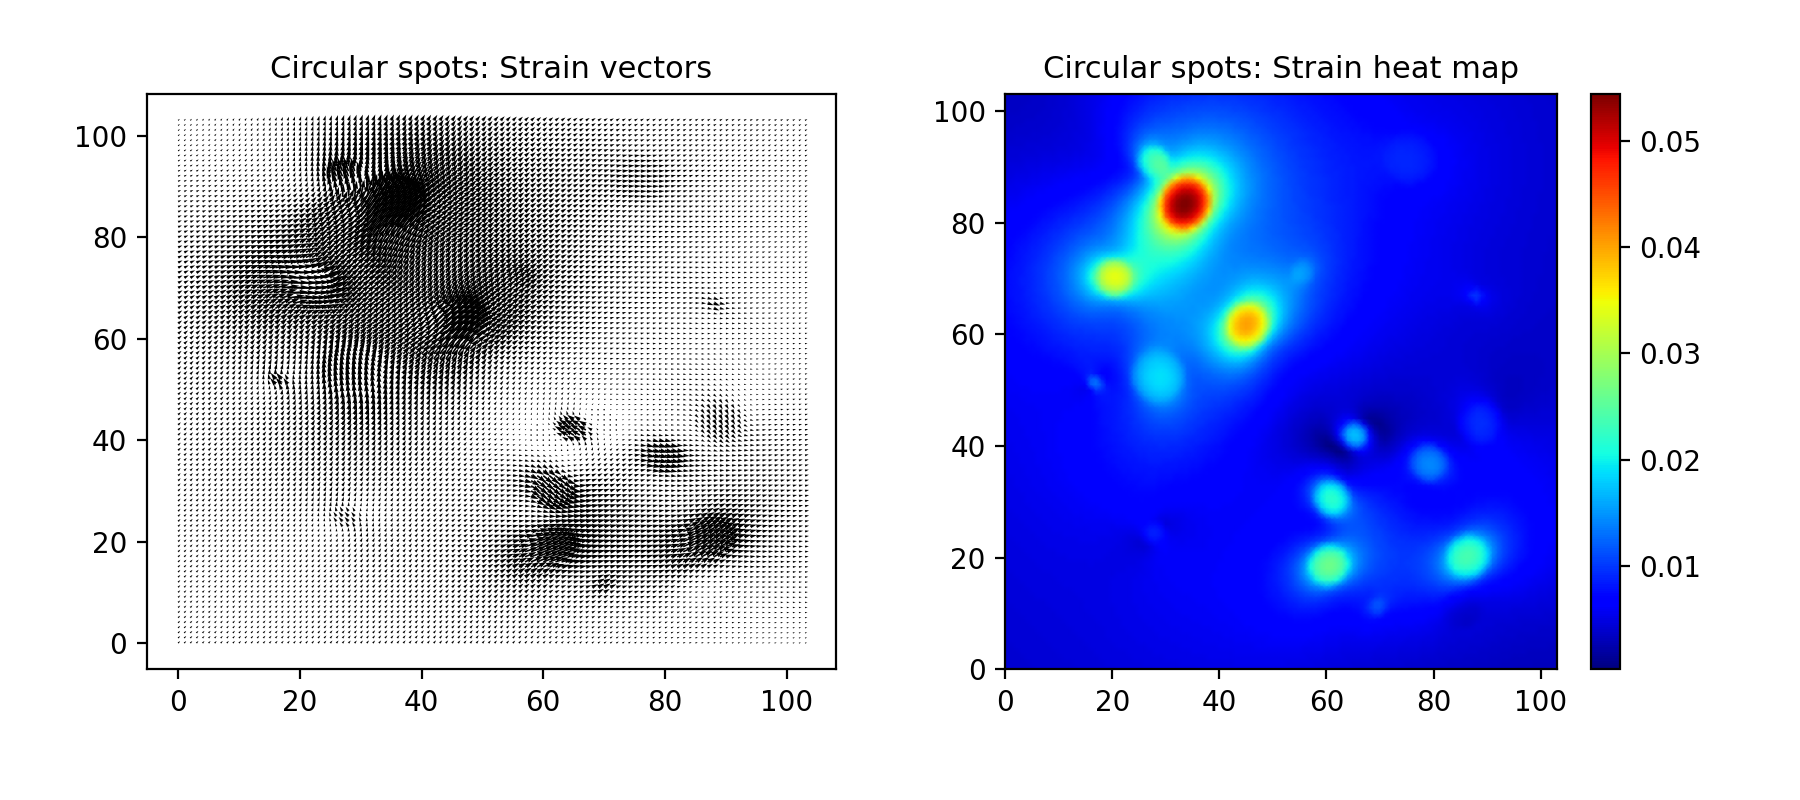

Text(0.5, 1.0, 'Circular spots: Strain heat map')

In [115]:
dspl = h5py.File('mltfm/displacement.h5')

get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(1,2, figsize=(9, 4))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)
axs[0].quiver(dspl['data'][0,:,:,0], dspl['data'][0,:,:,1], scale=1)
axs[0].set_title('Circular spots: Strain vectors', {'fontsize': 11})

C = np.sqrt(dspl['data'][0,:,:,0] **2 + dspl['data'][0,:,:,1] ** 2)
im = axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
fig.colorbar(im, ax=axs[1])
axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1].set_title('Circular spots: Strain heat map', {'fontsize': 11})

Plot ground truth and predictions.

In [116]:
gt = h5py.File('mltfm/tractions.h5')

predictions = {}
predictions['TracNet_SGD_Pytorch'] = np.moveaxis(predictTrac(torch.from_numpy(reshape(dspl['data'][0,:,:,:][np.newaxis, :])), TracNet_Pytorch_SGD, E=10670).detach().numpy()[0][0], [0,2], [2,0])
predictions['TracNet_ADAM_Pytorch'] = np.moveaxis(predictTrac(torch.from_numpy(reshape(dspl['data'][0,:,:,:][np.newaxis, :])), TracNet_Pytorch_ADAM, E=10670).detach().numpy()[0][0], [0,2], [2,0])
predictions['low_noise_UNet'] = low_noise_UNet.predict(dspl['data'])
predictions['high_noise_UNet'] = high_noise_UNet.predict(dspl['data'])

In [165]:
# predictions['Easy-to-use_TFM-package']
# predictions['TracNet_Matlab']

savemat('test_data_for_DL-TFM.mat', {'dspl': dspl['data'][0,:,:,:]})

x, y = np.meshgrid(np.arange(1, 105, 1), np.arange(1, 105, 1))
pos = np.zeros((104*104, 2))
pos[:,0] = np.ndarray.flatten(x)
pos[:,1] = np.ndarray.flatten(y)
noise = np.zeros((104*104, 2))
vec = np.zeros((104*104, 2))
vec[:,0] = np.ndarray.flatten(dspl['data'][0,:,:,0])
vec[:,0] = np.ndarray.flatten(dspl['data'][0,:,:,1])

In [166]:
noise = {'pos': pos, 'vec': noise}
displacement = {'pos': pos, 'vec': vec}
savemat('test_data_for_BFTTC.mat', {'input_data': {'noise': noise, 'displacement': displacement}})

<IPython.core.display.Javascript object>


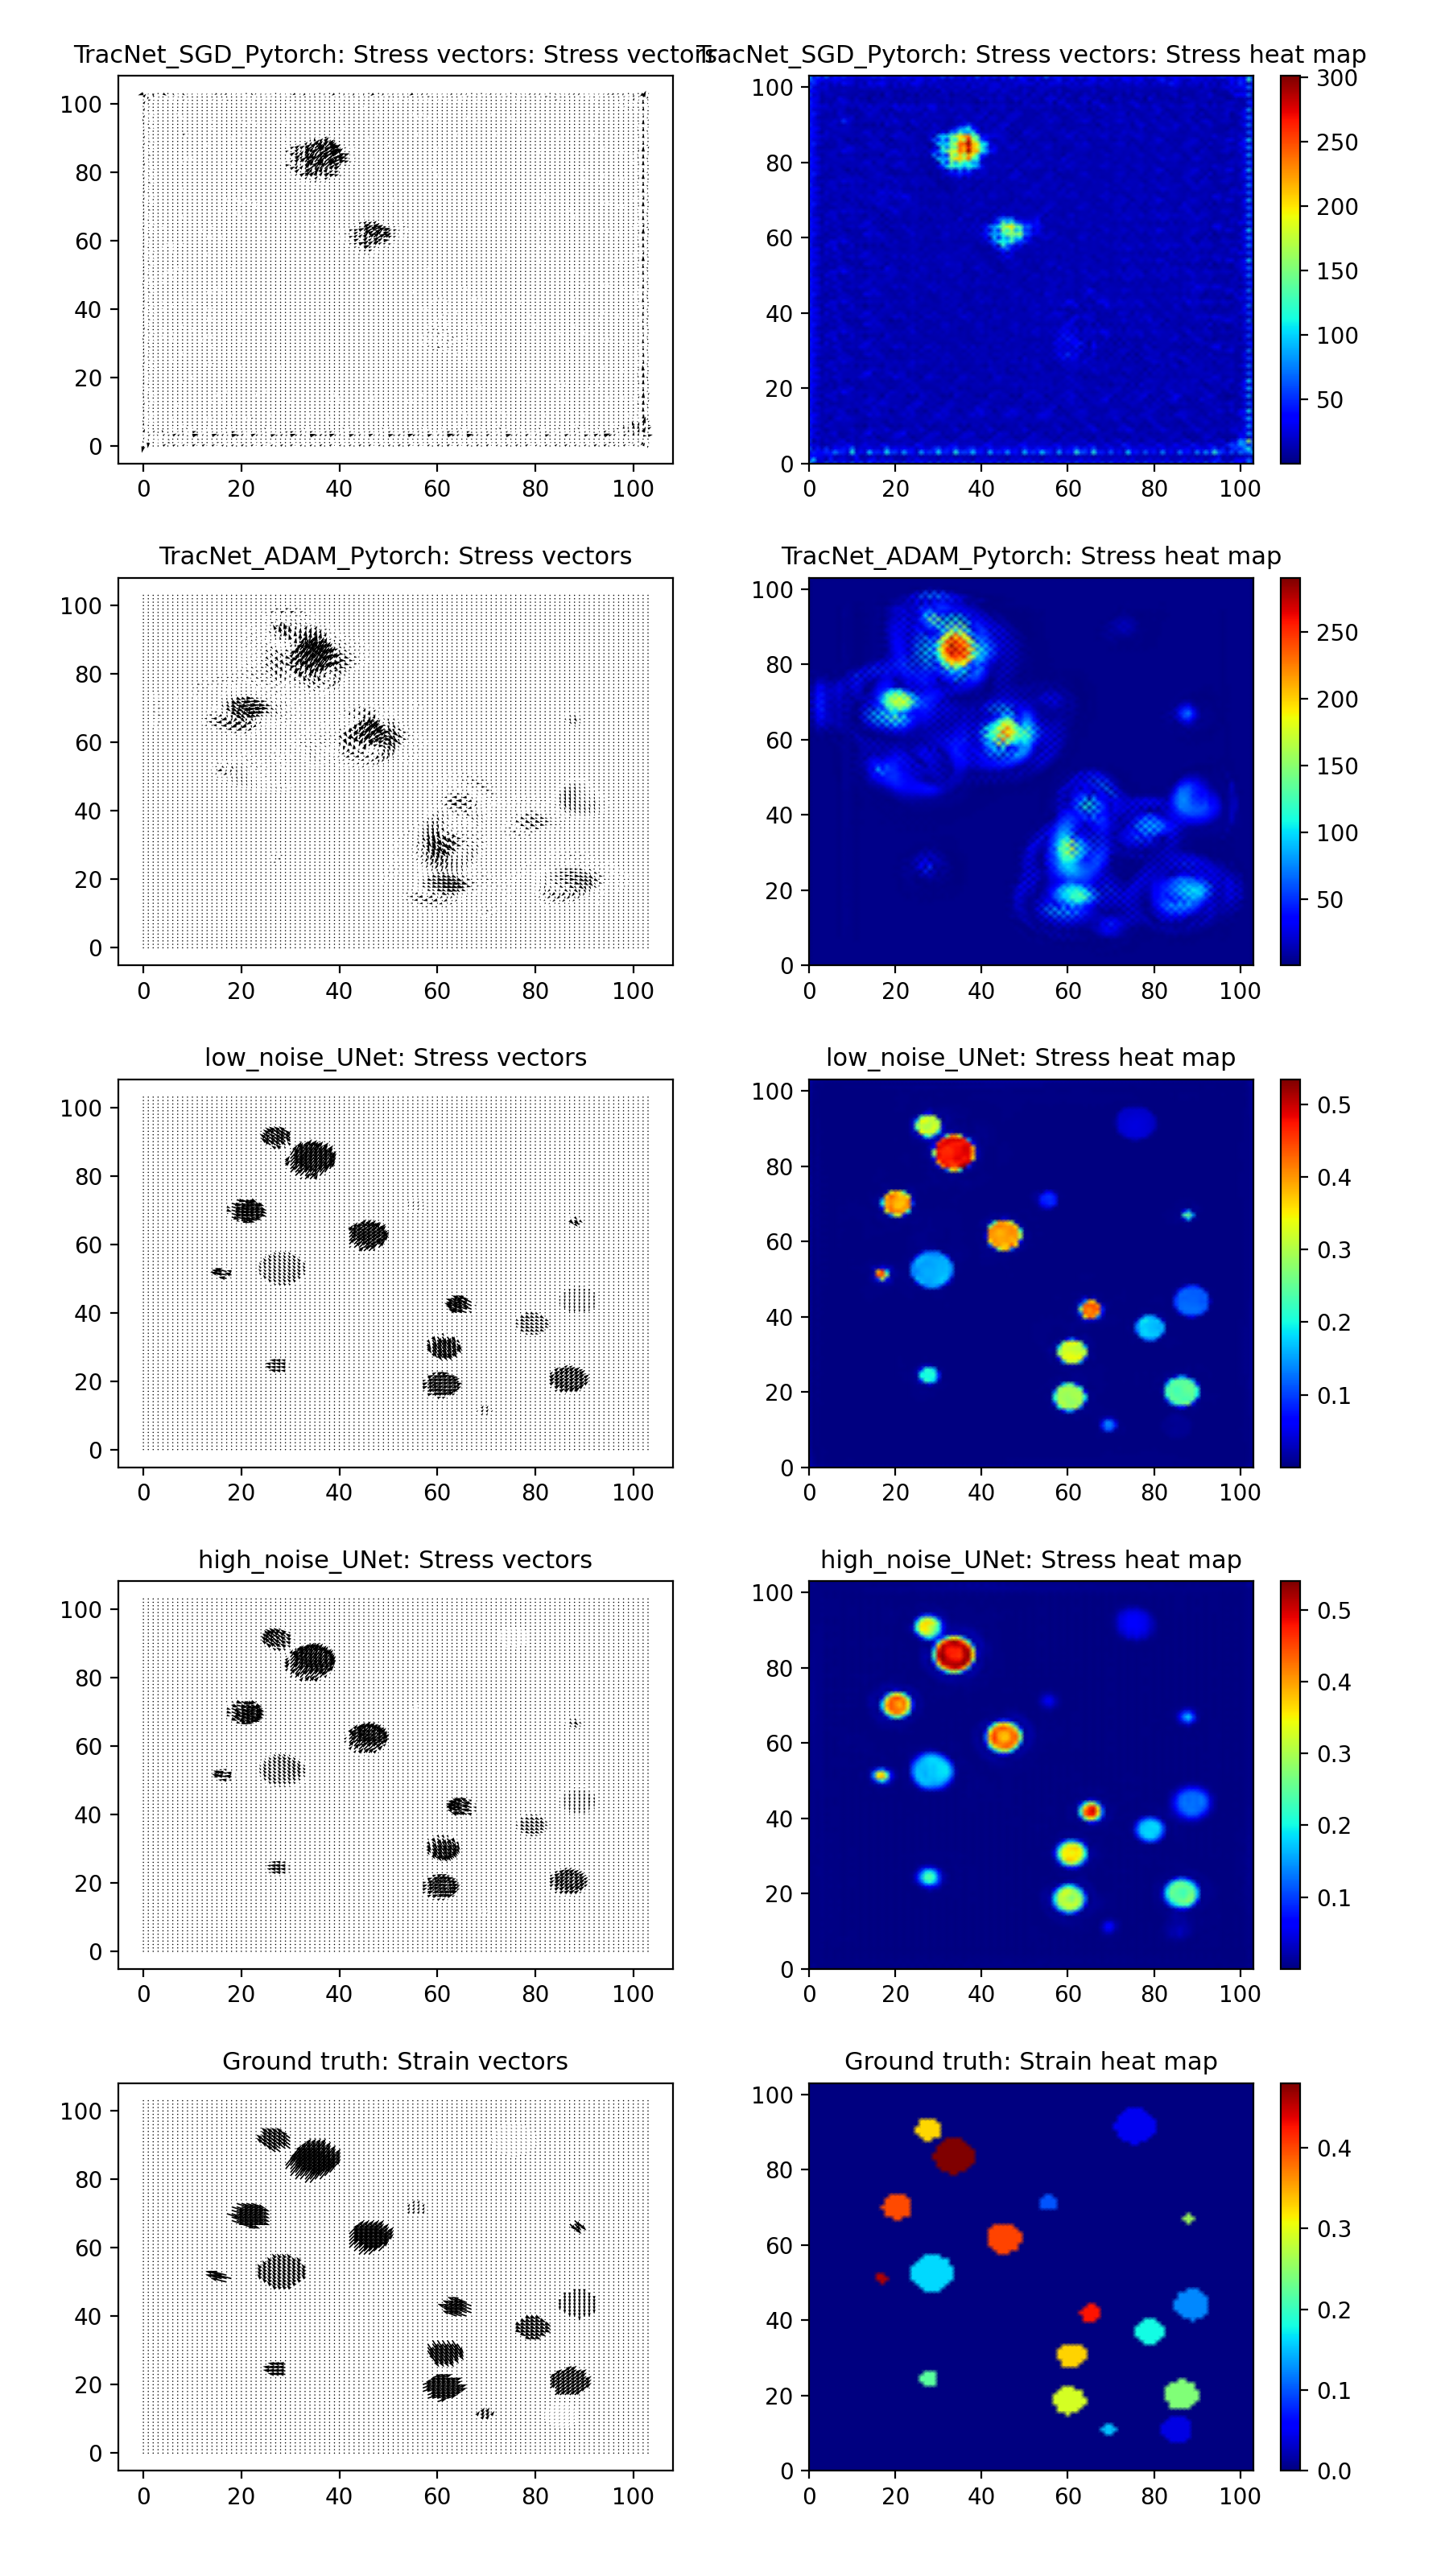

In [167]:
get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(5, 2, figsize=(9, 16))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0, 0].quiver(predictions['TracNet_SGD_Pytorch'][:,:,0], predictions['TracNet_SGD_Pytorch'][:,:,1], scale=10000)
axs[0, 0].set_title('TracNet_SGD_Pytorch: Stress vectors: Stress vectors', {'fontsize': 11})

C = np.sqrt(predictions['TracNet_SGD_Pytorch'][:,:,0] ** 2 + predictions['TracNet_SGD_Pytorch'][:,:,1] ** 2)
im = axs[0,1].pcolormesh(C, cmap='jet', shading='gouraud')
fig.colorbar(im, ax=axs[0,1])
axs[0,1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[0,1].set_title('TracNet_SGD_Pytorch: Stress vectors: Stress heat map', {'fontsize': 11})

axs[1, 0].quiver(predictions['TracNet_ADAM_Pytorch'][:,:,0], predictions['TracNet_ADAM_Pytorch'][:,:,1], scale=10000)
axs[1, 0].set_title('TracNet_ADAM_Pytorch: Stress vectors', {'fontsize': 11})

C = np.sqrt(predictions['TracNet_ADAM_Pytorch'][:,:,0] ** 2 + predictions['TracNet_ADAM_Pytorch'][:,:,1] ** 2)
im = axs[1,1].pcolormesh(C, cmap='jet', shading='gouraud')
fig.colorbar(im, ax=axs[1,1])
axs[1,1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1,1].set_title('TracNet_ADAM_Pytorch: Stress heat map', {'fontsize': 11})

axs[2, 0].quiver(predictions['low_noise_UNet'][0,:,:,0], predictions['low_noise_UNet'][0,:,:,1], scale=20)
axs[2, 0].set_title('low_noise_UNet: Stress vectors', {'fontsize': 11})

C = np.sqrt(predictions['low_noise_UNet'][0,:,:,0] ** 2 + predictions['low_noise_UNet'][0,:,:,1] ** 2)
im = axs[2,1].pcolormesh(C, cmap='jet', shading='gouraud')
fig.colorbar(im, ax=axs[2,1])
axs[2,1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[2,1].set_title('low_noise_UNet: Stress heat map', {'fontsize': 11})

axs[3, 0].quiver(predictions['high_noise_UNet'][0,:,:,0], predictions['high_noise_UNet'][0,:,:,1], scale=20)
axs[3, 0].set_title('high_noise_UNet: Stress vectors', {'fontsize': 11})

C = np.sqrt(predictions['high_noise_UNet'][0,:,:,0] ** 2 + predictions['high_noise_UNet'][0,:,:,1] ** 2)
im = axs[3,1].pcolormesh(C, cmap='jet', shading='gouraud')
fig.colorbar(im, ax=axs[3,1])
axs[3,1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[3,1].set_title('high_noise_UNet: Stress heat map', {'fontsize': 11})

axs[4, 0].quiver(gt['data'][0,:,:,0], gt['data'][0,:,:,1], scale=15)
axs[4, 0].set_title('Ground truth: Strain vectors', {'fontsize': 11})

C = np.sqrt(gt['data'][0,:,:,0] **2 + gt['data'][0,:,:,1] ** 2)
im = axs[4, 1].pcolormesh(C, cmap='jet', shading='gouraud')
fig.colorbar(im, ax=axs[4,1])
axs[4, 1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[4, 1].set_title('Ground truth: Strain heat map', {'fontsize': 11})


plt.show()